In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
df = pd.read_csv('Amazon Sales FY2020-21.csv')
valid_statuses = ['complete', 'received', 'canceled', 'order_refunded', 'refund']
df_filtered = df[df['status'].isin(valid_statuses)].copy()
complete_statuses = ['complete', 'received']
df_filtered['is_complete'] = df_filtered['status'].isin(complete_statuses).astype(int)
columns_to_drop = [
    'order_id', 'item_id', 'sku', 'ref_num', 
    'Name Prefix', 'First Name', 'Middle Initial', 'Last Name', 'full_name',
    'E Mail', 'User Name', 'cust_id', 'Phone No. ', 'bi_st',
    'status'
]

df_model = df_filtered.drop(columns=columns_to_drop)


In [6]:
order_date_parsed = None

if 'order_date' in df_model.columns:
    order_date_parsed = pd.to_datetime(df_model['order_date'], format='%d/%m/%Y', errors='coerce')
    df_model['order_year'] = order_date_parsed.dt.year
    df_model['order_month'] = order_date_parsed.dt.month
    df_model['order_day'] = order_date_parsed.dt.day
    df_model['order_dayofweek'] = order_date_parsed.dt.dayofweek
    df_model = df_model.drop(columns=['order_date'])

if 'Sign in date' in df_model.columns:
    sign_in_date_parsed = pd.to_datetime(df_model['Sign in date'], errors='coerce')
    if order_date_parsed is not None:
        df_model['days_since_signup'] = (order_date_parsed - sign_in_date_parsed).dt.days
    else:
        df_model['days_since_signup'] = (pd.Timestamp.now() - sign_in_date_parsed).dt.days
    df_model = df_model.drop(columns=['Sign in date'], errors='ignore')



In [7]:
y = df_model['is_complete'].copy()
X = df_model.drop(columns=['is_complete'])
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

label_encoders = {}
X_encoded = X.copy()

if 'payment_method' in X_encoded.columns:
    X_encoded['payment_method'] = X_encoded['payment_method'].fillna('unknown')
    payment_method_dummies = pd.get_dummies(X_encoded['payment_method'], prefix='payment_method')
    X_encoded = X_encoded.drop(columns=['payment_method'])
    X_encoded = pd.concat([X_encoded, payment_method_dummies], axis=1)

for col in categorical_cols:
    if col in X_encoded.columns and col != 'payment_method':
        le = LabelEncoder()
        X_encoded[col] = X_encoded[col].fillna('unknown')
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=144, stratify=y
)



In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

        Total_Orders  Complete_Orders  Completion_Rate
Gender                                                
M             144129            72220         0.501079
F             138313            68523         0.495420


<Figure size 1000x600 with 0 Axes>

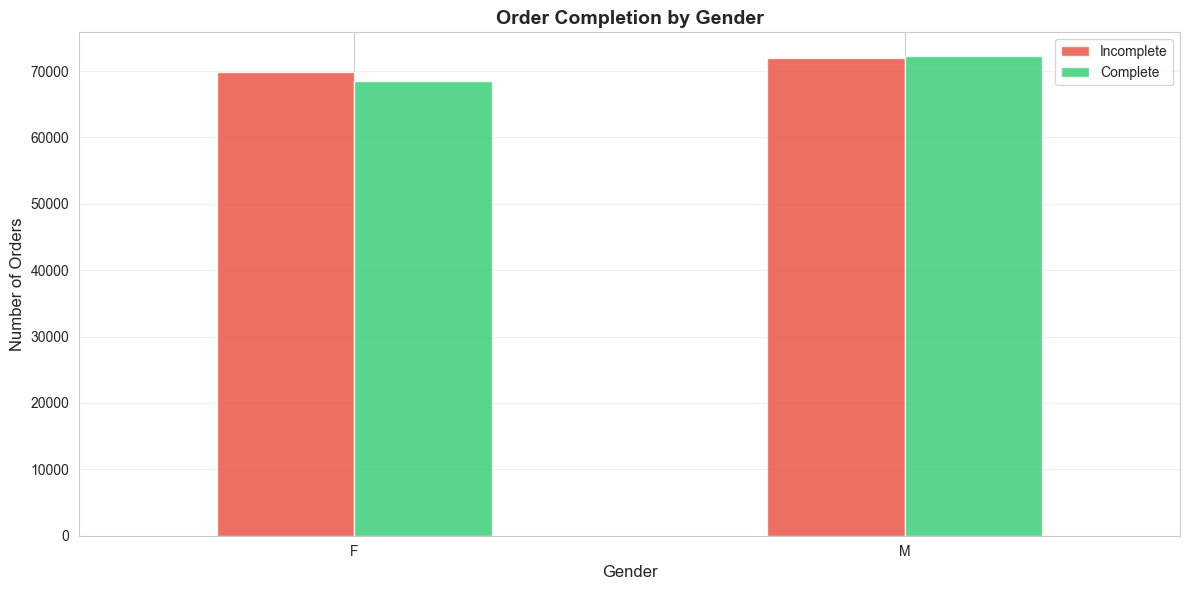

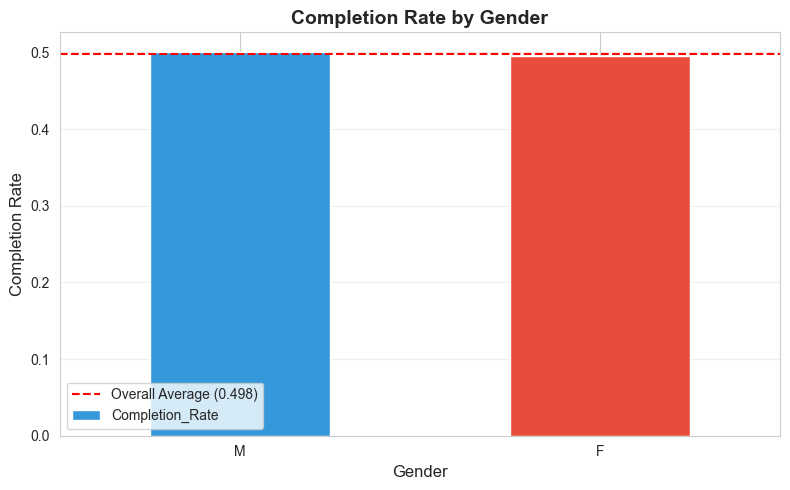

In [14]:
analysis_df = df_filtered.copy()

gender_analysis = analysis_df.groupby('Gender')['is_complete'].agg(['count', 'sum', 'mean'])
gender_analysis.columns = ['Total_Orders', 'Complete_Orders', 'Completion_Rate']
gender_analysis = gender_analysis.sort_values('Completion_Rate', ascending=False)
print(gender_analysis)

plt.figure(figsize=(10, 6))
gender_counts = analysis_df.groupby(['Gender', 'is_complete']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', stacked=False, color=['#e74c3c', '#2ecc71'], alpha=0.8)
plt.title('Order Completion by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.legend(['Incomplete', 'Complete'], loc='upper right')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
gender_analysis['Completion_Rate'].plot(kind='bar', color=['#3498db', '#e74c3c'])
plt.title('Completion Rate by Gender', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Completion Rate', fontsize=12)
plt.xticks(rotation=0)
plt.axhline(y=analysis_df['is_complete'].mean(), color='r', linestyle='--', 
            label=f'Overall Average ({analysis_df["is_complete"].mean():.3f})')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



           Total_Orders  Complete_Orders  Completion_Rate
Region                                                   
Midwest           80108            40336         0.503520
West              50484            25178         0.498732
Northeast         49675            24610         0.495420
South            102175            50619         0.495415


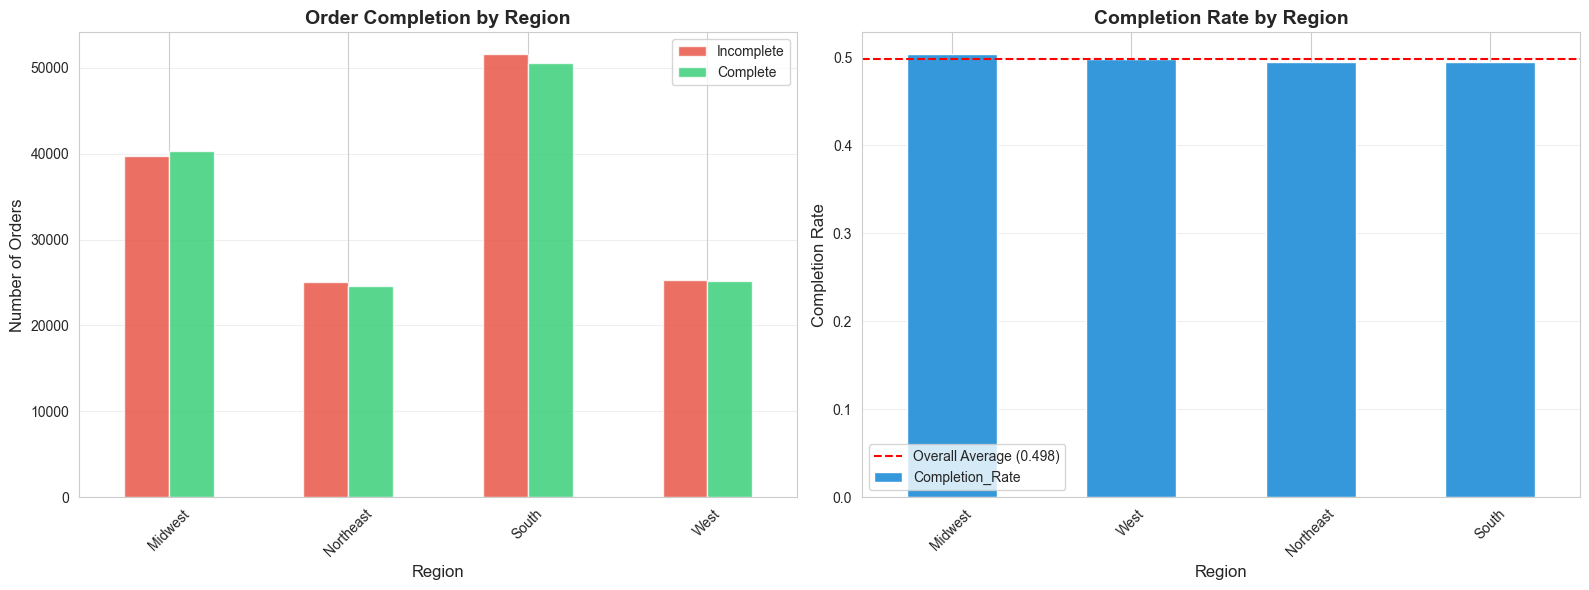

In [15]:
region_analysis = analysis_df.groupby('Region')['is_complete'].agg(['count', 'sum', 'mean'])
region_analysis.columns = ['Total_Orders', 'Complete_Orders', 'Completion_Rate']
region_analysis = region_analysis.sort_values('Completion_Rate', ascending=False)
print(region_analysis)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

region_counts = analysis_df.groupby(['Region', 'is_complete']).size().unstack(fill_value=0)
region_counts.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'], alpha=0.8)
axes[0].set_title('Order Completion by Region', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Region', fontsize=12)
axes[0].set_ylabel('Number of Orders', fontsize=12)
axes[0].legend(['Incomplete', 'Complete'], loc='upper right')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

region_analysis['Completion_Rate'].plot(kind='bar', ax=axes[1], color='#3498db')
axes[1].set_title('Completion Rate by Region', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Region', fontsize=12)
axes[1].set_ylabel('Completion Rate', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=analysis_df['is_complete'].mean(), color='r', linestyle='--', 
                label=f'Overall Average ({analysis_df["is_complete"].mean():.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



                   Total_Orders  Complete_Orders  Completion_Rate
payment_method                                                   
cashatdoorstep                9                9         1.000000
customercredit             3588             2812         0.783724
cod                       99932            68683         0.687297
easypay_voucher           29710            17842         0.600539
jazzvoucher                6027             2645         0.438858
mcblite                     208               88         0.423077
Payaxis                   30826            12077         0.391780
Easypay                   69468            24761         0.356437
jazzwallet                 6640             2272         0.342169
Easypay_MA                11506             3471         0.301669
bankalfalah               22789             5751         0.252359
apg                        1738              332         0.191024
financesettlement             1                0         0.000000


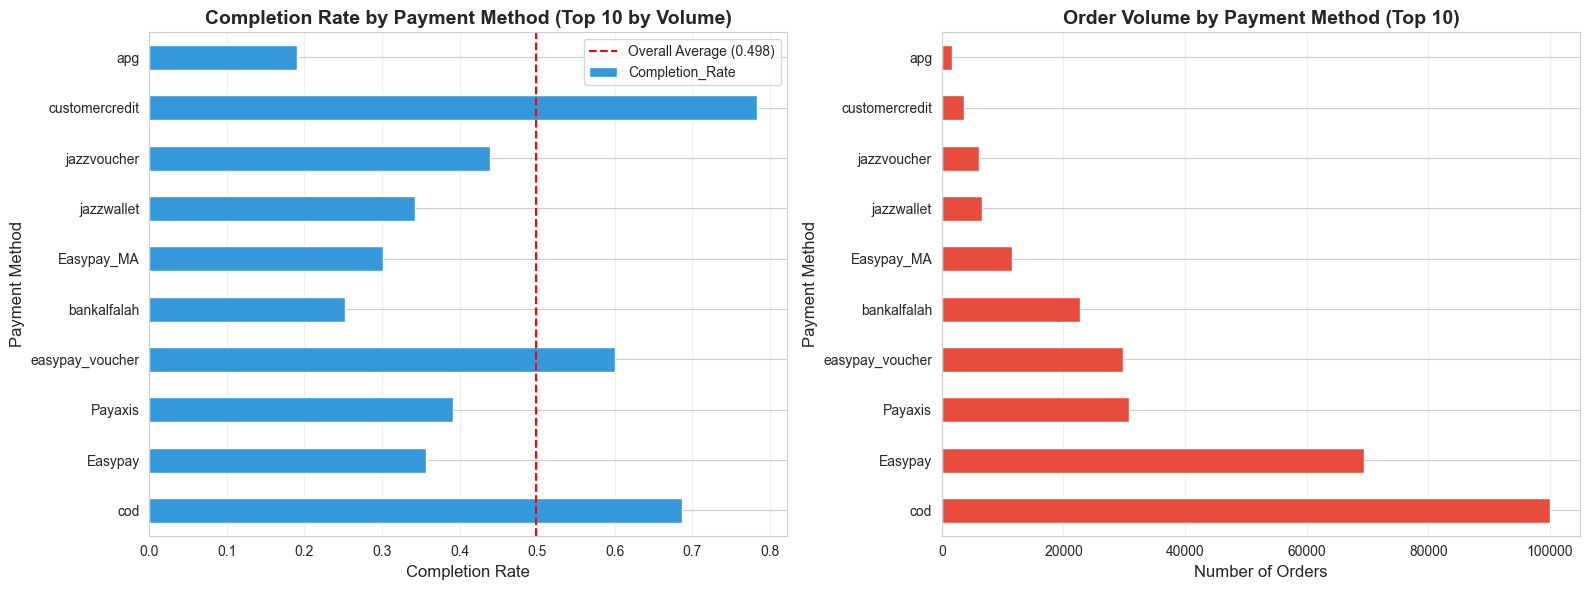

In [16]:
payment_analysis = analysis_df.groupby('payment_method')['is_complete'].agg(['count', 'sum', 'mean'])
payment_analysis.columns = ['Total_Orders', 'Complete_Orders', 'Completion_Rate']
payment_analysis = payment_analysis.sort_values('Completion_Rate', ascending=False)
print(payment_analysis)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_payment = payment_analysis.nlargest(10, 'Total_Orders')
top_payment['Completion_Rate'].plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Completion Rate by Payment Method (Top 10 by Volume)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Completion Rate', fontsize=12)
axes[0].set_ylabel('Payment Method', fontsize=12)
axes[0].axvline(x=analysis_df['is_complete'].mean(), color='r', linestyle='--', 
                label=f'Overall Average ({analysis_df["is_complete"].mean():.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

top_payment['Total_Orders'].plot(kind='barh', ax=axes[1], color='#e74c3c')
axes[1].set_title('Order Volume by Payment Method (Top 10)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Orders', fontsize=12)
axes[1].set_ylabel('Payment Method', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()



                    Total_Orders  Complete_Orders  Completion_Rate
category                                                          
Health & Sports             8322             5650         0.678923
Books                        725              482         0.664828
Superstore                 14689             8999         0.612635
Beauty & Grooming          17439            10359         0.594013
Home & Living              13515             7869         0.582242
Soghaat                     7071             4031         0.570075
Kids & Baby                 6289             3526         0.560661
Women's Fashion            27716            15386         0.555131
Men's Fashion              40012            21450         0.536089
School & Education          1064              543         0.510338
Appliances                 32842            16513         0.502801
Entertainment              17292             8467         0.489648
Computing                   8009             3553         0.44

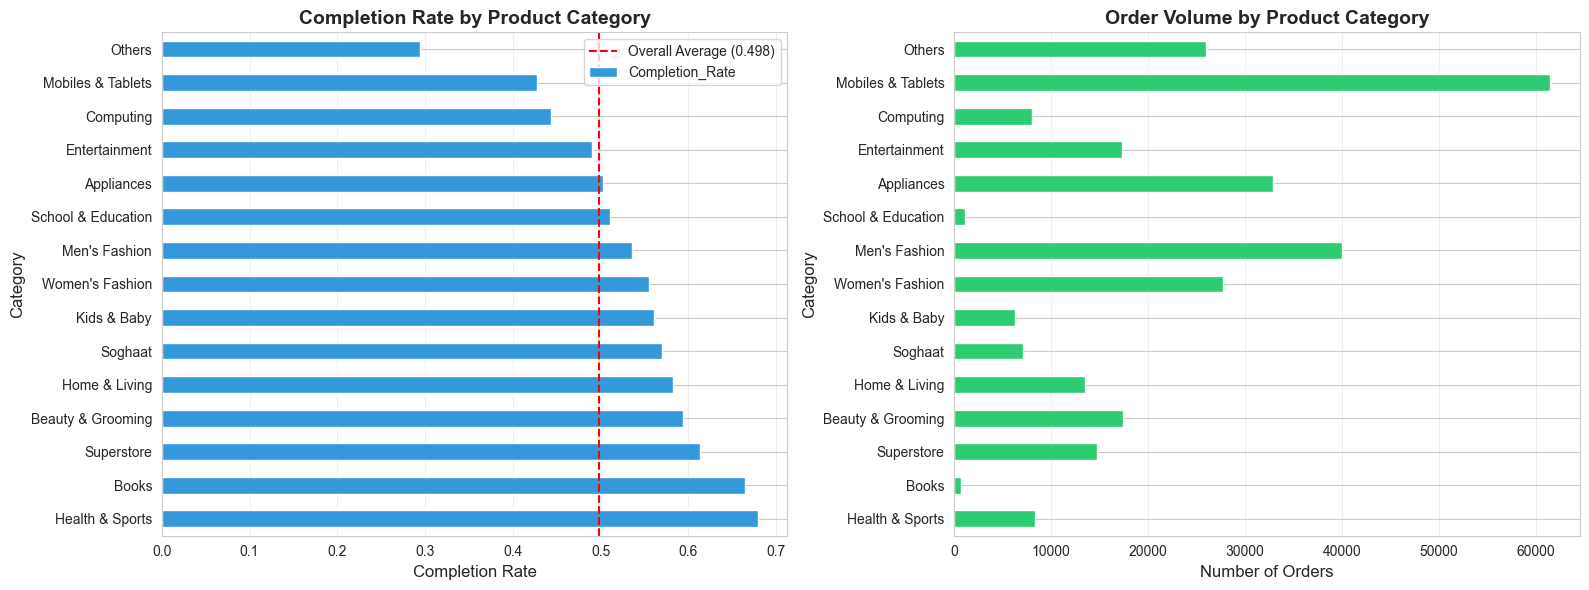

In [17]:
category_analysis = analysis_df.groupby('category')['is_complete'].agg(['count', 'sum', 'mean'])
category_analysis.columns = ['Total_Orders', 'Complete_Orders', 'Completion_Rate']
category_analysis = category_analysis.sort_values('Completion_Rate', ascending=False)
print(category_analysis)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

category_analysis['Completion_Rate'].plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Completion Rate by Product Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Completion Rate', fontsize=12)
axes[0].set_ylabel('Category', fontsize=12)
axes[0].axvline(x=analysis_df['is_complete'].mean(), color='r', linestyle='--', 
                label=f'Overall Average ({analysis_df["is_complete"].mean():.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

category_analysis['Total_Orders'].plot(kind='barh', ax=axes[1], color='#2ecc71')
axes[1].set_title('Order Volume by Product Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Orders', fontsize=12)
axes[1].set_ylabel('Category', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()




5. COMPLETION RATE BY STATE (Top 10 by Volume)
----------------------------------------------------------------------
       Total_Orders  Complete_Orders  Completion_Rate
State                                                
IL            12497             6901         0.552213
MO             8721             4589         0.526201
CA            16904             8835         0.522657
VA             8415             4273         0.507784
NY            15207             7585         0.498783
OH             9990             4950         0.495495
PA            14182             6994         0.493160
TX            17275             8518         0.493082
FL            10425             4968         0.476547
IA             8073             3798         0.470457


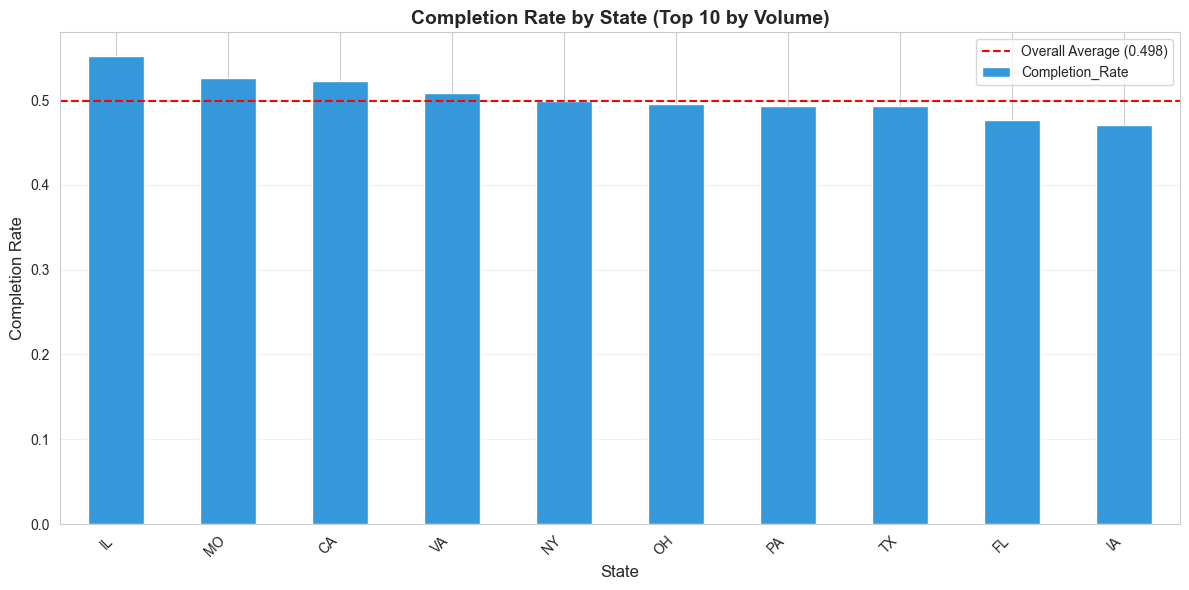

In [40]:
# Analyze by State (Top 10 by volume)
print("\n5. COMPLETION RATE BY STATE (Top 10 by Volume)")
print("-" * 70)
state_analysis = analysis_df.groupby('State')['is_complete'].agg(['count', 'sum', 'mean'])
state_analysis.columns = ['Total_Orders', 'Complete_Orders', 'Completion_Rate']
state_analysis = state_analysis.sort_values('Total_Orders', ascending=False).head(10)
state_analysis = state_analysis.sort_values('Completion_Rate', ascending=False)
print(state_analysis)

# Visualize
plt.figure(figsize=(12, 6))
state_analysis['Completion_Rate'].plot(kind='bar', color='#3498db')
plt.title('Completion Rate by State (Top 10 by Volume)', fontsize=14, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Completion Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=analysis_df['is_complete'].mean(), color='r', linestyle='--', 
            label=f'Overall Average ({analysis_df["is_complete"].mean():.3f})')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



                  Total_Orders  Complete_Orders  Completion_Rate
Gender Region                                                   
M      Midwest           42630            21767         0.510603
       West              24706            12497         0.505829
       Northeast         25502            12793         0.501647
F      South             50884            25456         0.500275
       Midwest           37478            18569         0.495464
       West              25778            12681         0.491931
M      South             51291            25163         0.490593
F      Northeast         24173            11817         0.488851


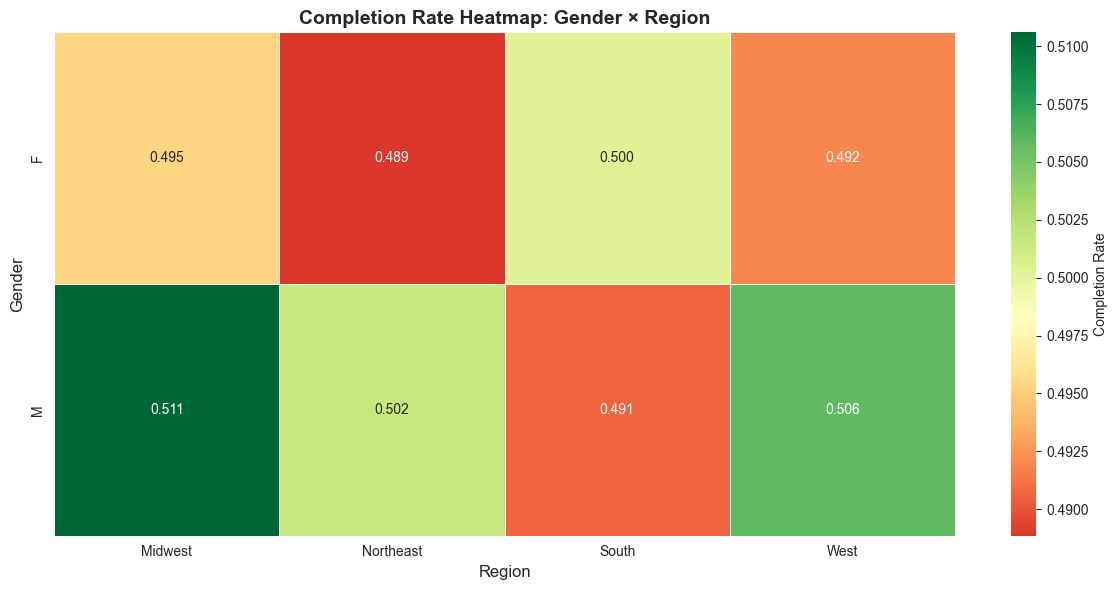

In [18]:
combined_analysis = analysis_df.groupby(['Gender', 'Region'])['is_complete'].agg(['count', 'sum', 'mean'])
combined_analysis.columns = ['Total_Orders', 'Complete_Orders', 'Completion_Rate']
combined_analysis = combined_analysis.sort_values('Completion_Rate', ascending=False)
print(combined_analysis.head(15))

pivot_table = analysis_df.groupby(['Gender', 'Region'])['is_complete'].mean().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlGn', center=analysis_df['is_complete'].mean(),
            cbar_kws={'label': 'Completion Rate'}, linewidths=0.5)
plt.title('Completion Rate Heatmap: Gender × Region', fontsize=14, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Gender', fontsize=12)
plt.tight_layout()
plt.show()



In [19]:
print("="*80)
print("TRAINING DECISION TREES ON CONDITIONED SUBSETS")
print("="*80)

conditioned_results = []

def train_conditioned_model(subset_name, filtered_df):
    if len(filtered_df) < 100: 
        return None
    
    df_model_subset = filtered_df.drop(columns=columns_to_drop, errors='ignore')

    order_date_parsed = None
    if 'order_date' in df_model_subset.columns:
        order_date_parsed = pd.to_datetime(df_model_subset['order_date'], format='%d/%m/%Y', errors='coerce')
        df_model_subset['order_year'] = order_date_parsed.dt.year
        df_model_subset['order_month'] = order_date_parsed.dt.month
        df_model_subset['order_day'] = order_date_parsed.dt.day
        df_model_subset['order_dayofweek'] = order_date_parsed.dt.dayofweek
        df_model_subset = df_model_subset.drop(columns=['order_date'])
    
    if 'Sign in date' in df_model_subset.columns:
        sign_in_date_parsed = pd.to_datetime(df_model_subset['Sign in date'], errors='coerce')
        if order_date_parsed is not None:
            df_model_subset['days_since_signup'] = (order_date_parsed - sign_in_date_parsed).dt.days
        else:
            df_model_subset['days_since_signup'] = (pd.Timestamp.now() - sign_in_date_parsed).dt.days
        df_model_subset = df_model_subset.drop(columns=['Sign in date'], errors='ignore')

    y_subset = df_model_subset['is_complete'].copy()
    X_subset = df_model_subset.drop(columns=['is_complete'])

    X_subset_encoded = X_subset.copy()
    categorical_cols_subset = X_subset.select_dtypes(include=['object']).columns.tolist()
    numerical_cols_subset = X_subset.select_dtypes(include=[np.number]).columns.tolist()

    if 'payment_method' in X_subset_encoded.columns:
        X_subset_encoded['payment_method'] = X_subset_encoded['payment_method'].fillna('unknown')
        payment_method_dummies = pd.get_dummies(X_subset_encoded['payment_method'], prefix='payment_method')
        X_subset_encoded = X_subset_encoded.drop(columns=['payment_method'])
        X_subset_encoded = pd.concat([X_subset_encoded, payment_method_dummies], axis=1)

    for col in categorical_cols_subset:
        if col in X_subset_encoded.columns and col != 'payment_method':
            le = LabelEncoder()
            X_subset_encoded[col] = X_subset_encoded[col].fillna('unknown')
            X_subset_encoded[col] = le.fit_transform(X_subset_encoded[col].astype(str))

    for col in numerical_cols_subset:
        if col in X_subset_encoded.columns:
            X_subset_encoded[col] = X_subset_encoded[col].fillna(X_subset_encoded[col].median())

    if len(X_subset_encoded) < 200:
        test_size = 0.15
    else:
        test_size = 0.2
    
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        X_subset_encoded, y_subset, test_size=test_size, random_state=42, stratify=y_subset
    )

    dt_subset = DecisionTreeClassifier(random_state=42)
    dt_subset.fit(X_train_subset, y_train_subset)

    y_pred_subset = dt_subset.predict(X_test_subset)
    accuracy_subset = accuracy_score(y_test_subset, y_pred_subset)

    cv_scores_subset = cross_val_score(dt_subset, X_train_subset, y_train_subset, cv=5, scoring='accuracy')

    y_pred_proba_subset = dt_subset.predict_proba(X_test_subset)[:, 1]
    auc_subset = roc_auc_score(y_test_subset, y_pred_proba_subset)
    
    return {
        'subset_name': subset_name,
        'n_samples': len(filtered_df),
        'test_accuracy': accuracy_subset,
        'cv_mean': cv_scores_subset.mean(),
        'cv_std': cv_scores_subset.std(),
        'roc_auc': auc_subset
    }


In [20]:
print("Training models conditioned on GENDER...")
for gender in analysis_df['Gender'].unique():
    if pd.isna(gender):
        continue
    gender_df = analysis_df[analysis_df['Gender'] == gender].copy()
    result = train_conditioned_model(f"Gender: {gender}", gender_df)
    if result:
        conditioned_results.append(result)
        print(f"  ✓ {result['subset_name']}: Test Acc = {result['test_accuracy']:.4f}, CV Acc = {result['cv_mean']:.4f}")

print()



Gender: F: Test Acc = 0.7390, CV Acc = 0.7252
Gender: M: Test Acc = 0.7352, CV Acc = 0.7271


In [21]:
print("Training models conditioned on REGION (Top 5 by volume)...")
top_regions = analysis_df['Region'].value_counts().head(5).index
for region in top_regions:
    if pd.isna(region):
        continue
    region_df = analysis_df[analysis_df['Region'] == region].copy()
    result = train_conditioned_model(f"Region: {region}", region_df)
    if result:
        conditioned_results.append(result)
        print(f"  ✓ {result['subset_name']}: Test Acc = {result['test_accuracy']:.4f}, CV Acc = {result['cv_mean']:.4f}")



Region: South: Test Acc = 0.7326, CV Acc = 0.7227
Region: Midwest: Test Acc = 0.7346, CV Acc = 0.7332
Region: West: Test Acc = 0.7349, CV Acc = 0.7240
Region: Northeast: Test Acc = 0.7406, CV Acc = 0.7286


In [22]:
print("Training models conditioned on PAYMENT METHOD (Top 5 by volume)...")
top_payment_methods = analysis_df['payment_method'].value_counts().head(5).index
for payment in top_payment_methods:
    if pd.isna(payment):
        continue
    payment_df = analysis_df[analysis_df['payment_method'] == payment].copy()
    result = train_conditioned_model(f"Payment: {payment}", payment_df)
    if result:
        conditioned_results.append(result)
        print(f"  ✓ {result['subset_name']}: Test Acc = {result['test_accuracy']:.4f}, CV Acc = {result['cv_mean']:.4f}")

print()



Payment: cod: Test Acc = 0.7204, CV Acc = 0.7100
Payment: Easypay: Test Acc = 0.7238, CV Acc = 0.7195
Payment: Payaxis: Test Acc = 0.7157, CV Acc = 0.7043
Payment: easypay_voucher: Test Acc = 0.7671, CV Acc = 0.7410
Payment: bankalfalah: Test Acc = 0.7817, CV Acc = 0.7595



In [23]:
print("Training models conditioned on CATEGORY (Top 5 by volume)...")
top_categories = analysis_df['category'].value_counts().head(5).index
for category in top_categories:
    if pd.isna(category):
        continue
    category_df = analysis_df[analysis_df['category'] == category].copy()
    result = train_conditioned_model(f"Category: {category}", category_df)
    if result:
        conditioned_results.append(result)
        print(f"  ✓ {result['subset_name']}: Test Acc = {result['test_accuracy']:.4f}, CV Acc = {result['cv_mean']:.4f}")

print()



Category: Mobiles & Tablets: Test Acc = 0.7546, CV Acc = 0.7427
Category: Men's Fashion: Test Acc = 0.7175, CV Acc = 0.7124
Category: Appliances: Test Acc = 0.6589, CV Acc = 0.6441
Category: Women's Fashion: Test Acc = 0.7569, CV Acc = 0.7317
Category: Others: Test Acc = 0.6768, CV Acc = 0.6763



In [24]:
print("Training models conditioned on GENDER + REGION combinations...")
combined_counts = analysis_df.groupby(['Gender', 'Region']).size().sort_values(ascending=False).head(5)
for (gender, region), count in combined_counts.items():
    if pd.isna(gender) or pd.isna(region):
        continue
    combined_df = analysis_df[(analysis_df['Gender'] == gender) & (analysis_df['Region'] == region)].copy()
    result = train_conditioned_model(f"Gender: {gender}, Region: {region}", combined_df)
    if result:
        conditioned_results.append(result)
        print(f"  ✓ {result['subset_name']}: Test Acc = {result['test_accuracy']:.4f}, CV Acc = {result['cv_mean']:.4f}")

print()



Gender: M, Region: South: Test Acc = 0.7352, CV Acc = 0.7226
Gender: F, Region: South: Test Acc = 0.7479, CV Acc = 0.7257
Gender: M, Region: Midwest: Test Acc = 0.7450, CV Acc = 0.7308
Gender: F, Region: Midwest: Test Acc = 0.7421, CV Acc = 0.7313
Gender: F, Region: West: Test Acc = 0.7331, CV Acc = 0.7242



In [25]:
nn_model_improved = MLPClassifier(
    hidden_layer_sizes=(200, 100, 50), 
    activation='relu',    
    solver='adam',      
    alpha=0.0001,        
    learning_rate='constant',          
    learning_rate_init=0.001,  
    batch_size='auto',                 
    max_iter=1000,                  
    random_state=42,
    early_stopping=True,     
    validation_fraction=0.15,       
    n_iter_no_change=20,    
    tol=1e-5,   
    verbose=True
)

print("Training Improved Neural Network...")
print("Architecture: 3 hidden layers (200, 100, 50 neurons)")
print("This may take several minutes...\n")

nn_model_improved.fit(X_train_scaled, y_train)

print(f"\nTraining completed!")
print(f"Number of iterations: {nn_model_improved.n_iter_}")
print(f"Final Loss: {nn_model_improved.loss_:.4f}")



Training Improved Neural Network...
Architecture: 3 hidden layers (200, 100, 50 neurons)
This may take several minutes...

Iteration 1, loss = 0.58780856
Validation score: 0.695099
Iteration 2, loss = 0.57451505
Validation score: 0.697784
Iteration 3, loss = 0.56908703
Validation score: 0.702652
Iteration 4, loss = 0.56370801
Validation score: 0.702121
Iteration 5, loss = 0.55780057
Validation score: 0.707963
Iteration 6, loss = 0.55253635
Validation score: 0.709409
Iteration 7, loss = 0.54731851
Validation score: 0.709380
Iteration 8, loss = 0.54142881
Validation score: 0.709734
Iteration 9, loss = 0.53617106
Validation score: 0.709557
Iteration 10, loss = 0.53083396
Validation score: 0.713864
Iteration 11, loss = 0.52546860
Validation score: 0.717316
Iteration 12, loss = 0.52029193
Validation score: 0.715694
Iteration 13, loss = 0.51567036
Validation score: 0.717523
Iteration 14, loss = 0.51004487
Validation score: 0.715015
Iteration 15, loss = 0.50663190
Validation score: 0.719441
I

In [27]:
y_pred_nn_improved = nn_model_improved.predict(X_test_scaled)
accuracy_nn_improved = accuracy_score(y_test, y_pred_nn_improved)

print(f"Neural Network Accuracy: {accuracy_nn_improved:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn_improved, target_names=['Incomplete', 'Complete']))

y_pred_proba_nn_improved = nn_model_improved.predict_proba(X_test_scaled)[:, 1]
auc_score_nn_improved = roc_auc_score(y_test, y_pred_proba_nn_improved)

print(f"\nROC-AUC Score: {auc_score_nn_improved:.4f}")



Neural Network Accuracy: 0.7362

Classification Report:
              precision    recall  f1-score   support

  Incomplete       0.74      0.73      0.74     28340
    Complete       0.73      0.74      0.74     28149

    accuracy                           0.74     56489
   macro avg       0.74      0.74      0.74     56489
weighted avg       0.74      0.74      0.74     56489


ROC-AUC Score: 0.8060
